In [26]:
!pip install ucimlrepo seaborn

In [27]:
# @title 1. Setup & Load Dataset
!pip install ucimlrepo tensorflow pandas matplotlib seaborn scikit-learn joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from google.colab import files
from ucimlrepo import fetch_ucirepo

# Set style
sns.set_style("whitegrid")
np.random.seed(42)

# Buat folder output sementara
os.makedirs('output', exist_ok=True)

print("--- Loading Dataset ---")
online_news_popularity = fetch_ucirepo(id=332)
X_raw = online_news_popularity.data.features
y_raw = online_news_popularity.data.targets

# Gabungkan
df = pd.concat([X_raw, y_raw], axis=1)
# Bersihkan nama kolom (kadang ada spasi di awal)
df.columns = df.columns.str.strip()

print(f"✅ Dataset Loaded. Shape: {df.shape}")
display(df.head())

--- Loading Dataset ---
✅ Dataset Loaded. Shape: (39644, 59)


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [28]:
# @title 2. Data Cleaning

cols_to_drop = ['url', 'timedelta']
df_clean = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

print("✅ Kolom 'url' dan 'timedelta' dihapus.")
print("Missing Values:", df_clean.isnull().sum().sum())

✅ Kolom 'url' dan 'timedelta' dihapus.
Missing Values: 0


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (df is already loaded from ucimlrepo in cell aQUJU0GUEs7h)
# df = pd.read_csv('OnlineNewsPopularity.csv') # This line is causing the error
df.columns = df.columns.str.strip()

# --- Visualization 1: Distribution of Target Variable ---
plt.figure(figsize=(14, 6))

# Original Distribution (truncated for visibility)
plt.subplot(1, 2, 1)
sns.histplot(df[df['shares'] < 15000]['shares'], kde=True, bins=50, color='skyblue')
plt.title('Distribusi Shares (Di-zoom < 15,000)')
plt.xlabel('Jumlah Shares')
plt.ylabel('Frekuensi')

# Log Transformed Distribution
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['shares']), kde=True, bins=50, color='orange')
plt.title('Distribusi Log(Shares)')
plt.xlabel('Log(Shares)')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.savefig('vis1_distribution.png')
plt.close()

# --- Visualization 2: Correlation Heatmap ---
# Select relevant features for heatmap to avoid clutter
cols_to_corr = ['n_tokens_content', 'num_hrefs', 'num_imgs', 'num_videos',
                'average_token_length', 'global_subjectivity', 'global_sentiment_polarity',
                'kw_avg_avg', 'self_reference_avg_sharess', 'shares']
corr_matrix = df[cols_to_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Fitur Konten vs Shares')
plt.tight_layout()
plt.savefig('vis2_correlation.png')
plt.close()

# --- Visualization 3: Average Shares by Data Channel ---
# Create a single 'channel' column
channels = ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus',
            'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world']
channel_names = ['Lifestyle', 'Entertainment', 'Business', 'Social Media', 'Tech', 'World']

# Function to get channel name
def get_channel(row):
    for ch, name in zip(channels, channel_names):
        if row[ch] == 1:
            return name
    return 'Other'

df['channel'] = df.apply(get_channel, axis=1)

# Calculate average shares per channel
avg_shares_channel = df.groupby('channel')['shares'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_shares_channel.index, y=avg_shares_channel.values, hue=avg_shares_channel.index, palette='viridis', legend=False)
plt.title('Rata-rata Jumlah Shares per Kategori Berita')
plt.xlabel('Kategori (Channel)')
plt.ylabel('Rata-rata Shares')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('vis3_channel.png')
plt.close()

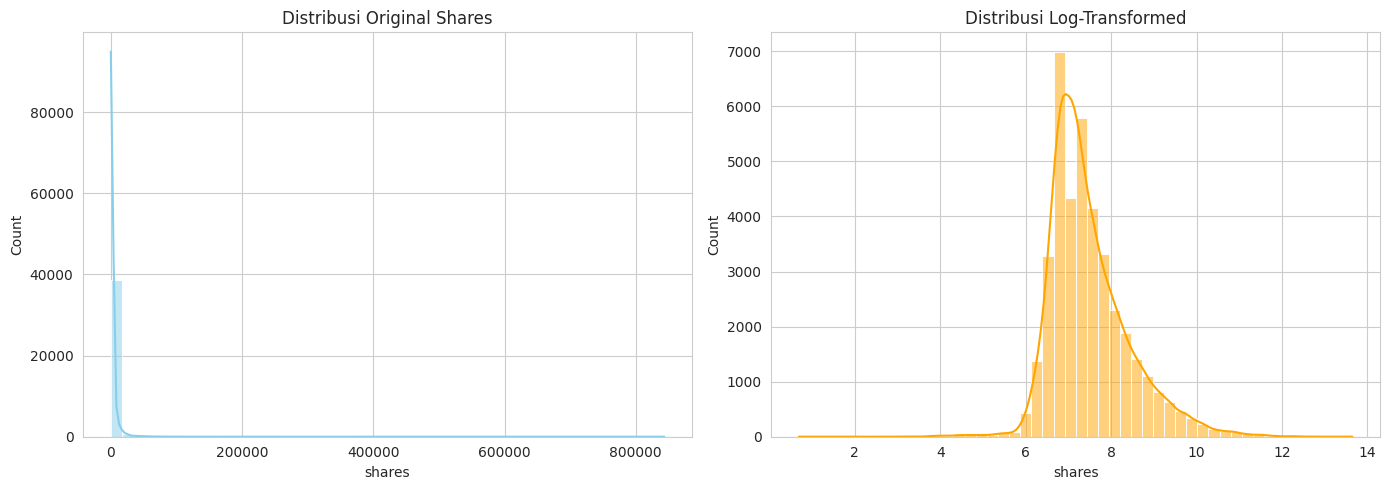

⬇️ Mengunduh distribusi_shares.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# @title 3. Visualisasi Distribusi Target
plt.figure(figsize=(14, 5))

# Plot Original
plt.subplot(1, 2, 1)
sns.histplot(df_clean['shares'], bins=50, kde=True, color='skyblue')
plt.title('Distribusi Original Shares')

# Plot Log Transformed
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_clean['shares']), bins=50, kde=True, color='orange')
plt.title('Distribusi Log-Transformed')

plt.tight_layout()
filename = 'distribusi_shares.png'
plt.savefig(filename)
plt.show()

# Auto Download
print(f"⬇️ Mengunduh {filename}...")
files.download(filename)

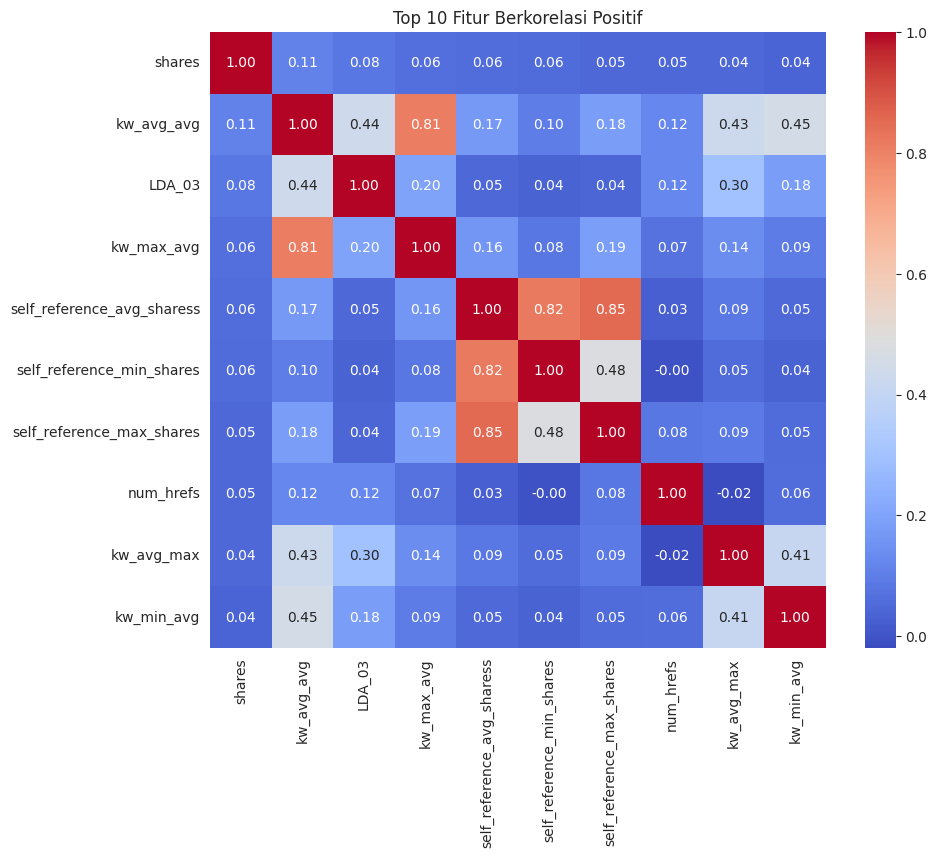

⬇️ Mengunduh heatmap_korelasi.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# @title 4. Visualisasi Heatmap Korelasi
plt.figure(figsize=(10, 8))

# Hitung korelasi
corr_matrix = df_clean.corr()
k = 10
cols = corr_matrix.nlargest(k, 'shares')['shares'].index
cm = np.corrcoef(df_clean[cols].values.T)

sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
            annot_kws={'size': 10}, yticklabels=cols.values,
            xticklabels=cols.values, cmap='coolwarm')
plt.title('Top 10 Fitur Berkorelasi Positif')

filename = 'heatmap_korelasi.png'
plt.savefig(filename)
plt.show()

# Auto Download
print(f"⬇️ Mengunduh {filename}...")
files.download(filename)

In [32]:
# @title 5. Data Splitting & Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Log Transform Target
y = np.log1p(df_clean['shares'])
X = df_clean.drop(columns=['shares'])

# 2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan & Download Scaler
joblib.dump(scaler, 'scaler.pkl')
print("✅ Data siap. Train shape:", X_train_scaled.shape)
print("⬇️ Mengunduh scaler.pkl...")
files.download('scaler.pkl')

✅ Data siap. Train shape: (31715, 58)
⬇️ Mengunduh scaler.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
# @title 6. Model 1: Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import os


os.makedirs('output_models', exist_ok=True)

# Train
print("Training Linear Regression...")
start_time = time.time()
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)
train_time_lr = time.time() - start_time

# Evaluate
y_pred_lr = lr_model.predict(X_test_scaled)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"✅ Linear Regression Results:")
print(f"   RMSE: {rmse_lr:.4f}")
print(f"   MAE : {mae_lr:.4f}")
print(f"   R2  : {r2_lr:.4f}")
print(f"   Time: {train_time_lr:.2f}s")

# Save
joblib.dump(lr_model, 'output_models/model_linear_regression.pkl')

Training Linear Regression...
✅ Linear Regression Results:
   RMSE: 0.8649
   MAE : 0.6440
   R2  : 0.1274
   Time: 0.22s


['output_models/model_linear_regression.pkl']

In [34]:
# @title 6. Model 2: Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import os
import time
import joblib

# Train
print("Training Random Forest.")
start_time = time.time()


rf_model_light = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_model_light.fit(X_train_scaled, y_train)
train_time_rf = time.time() - start_time

# 1. Lakukan Prediksi ke Data Test
y_pred_rf = rf_model_light.predict(X_test_scaled)

# 2. Hitung Metrik Evaluasi
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# 3. Tampilkan (Print) Hasilnya
print(f"✅ Random Forest Results:")
print(f"   RMSE: {rmse_rf:.4f}")
print(f"   MAE : {mae_rf:.4f}")
print(f"   R2  : {r2_rf:.4f}")
print(f"   Time: {train_time_rf:.2f}s")
# -----------------------------------

# Save Model
os.makedirs('output_models', exist_ok=True)
joblib.dump(rf_model_light, 'output_models/model_random_forest.pkl')

print("Selesai! Model disimpan sebagai 'model_random_forest.pkl'")

Training Random Forest.
✅ Random Forest Results:
   RMSE: 0.8447
   MAE : 0.6288
   R2  : 0.1676
   Time: 79.33s
Selesai! Model disimpan sebagai 'model_random_forest.pkl'


Training Deep Learning...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.1516 - mae: 2.2939 - val_loss: 9.2025 - val_mae: 0.8415
Epoch 2/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8808 - mae: 1.0520 - val_loss: 4.7308 - val_mae: 0.8415
Epoch 3/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5012 - mae: 0.9360 - val_loss: 2.8940 - val_mae: 0.7135
Epoch 4/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2475 - mae: 0.8513 - val_loss: 2.3596 - val_mae: 0.7472
Epoch 5/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1101 - mae: 0.7956 - val_loss: 1.6234 - val_mae: 0.6606
Epoch 6/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9934 - mae: 0.7527 - val_loss: 1.3751 - val_mae: 0.6684
Epoch 7/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9455 - mae: 0.7293 - val_loss: 1.2215 - val_mae: 0.6602
Epoch 8/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8720 - mae: 0.6927 - val_loss: 1.1437 - val_mae: 0.6599
Epoch 9/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8259

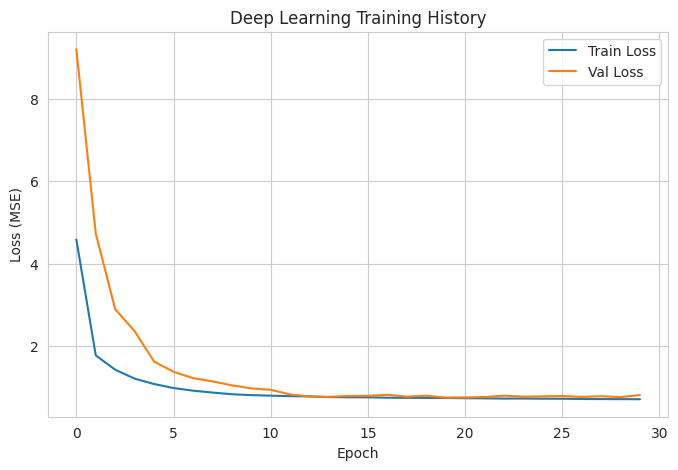

In [35]:
# @title 7. Model 3: Deep Learning (MLP)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt

# Ensure output directory exists for images
os.makedirs('output_images', exist_ok=True)

# Build Model
model_dl = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model_dl.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
print("Training Deep Learning...")
start_time = time.time()
history = model_dl.fit(
    X_train_scaled, y_train, validation_split=0.2,
    epochs=50, batch_size=64, callbacks=[early_stop], verbose=1
)
train_time_dl = time.time() - start_time

# Evaluate
y_pred_dl = model_dl.predict(X_test_scaled).flatten()
rmse_dl = np.sqrt(mean_squared_error(y_test, y_pred_dl))
mae_dl = mean_absolute_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)

print(f"✅ Deep Learning Results:")
print(f"   RMSE: {rmse_dl:.4f}")
print(f"   MAE : {mae_dl:.4f}")
print(f"   R2  : {r2_dl:.4f}")
print(f"   Time: {train_time_dl:.2f}s")

# Plot Loss & Save
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Deep Learning Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('output_images/dl_training_history.png')
plt.show()

# Save Model
model_dl.save('output_models/model_deep_learning.h5')

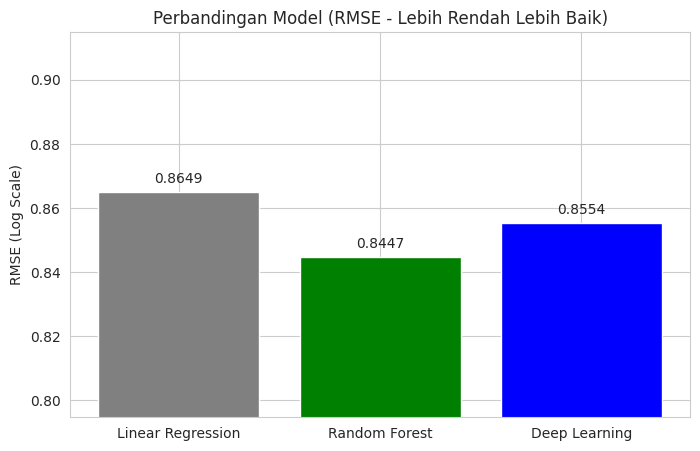

⬇️ Mengunduh model_comparison.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
# @title 9. Perbandingan Performa Model
models = ['Linear Regression', 'Random Forest', 'Deep Learning']
rmses = [rmse_lr, rmse_rf, rmse_dl]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, rmses, color=['gray', 'green', 'blue'])
plt.title('Perbandingan Model (RMSE - Lebih Rendah Lebih Baik)')
plt.ylabel('RMSE (Log Scale)')
plt.ylim(min(rmses)-0.05, max(rmses)+0.05) # Zoom agar terlihat bedanya

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, round(yval, 4), ha='center', va='bottom')

filename = 'model_comparison.png'
plt.savefig(filename)
plt.show()

# Auto Download
print(f"⬇️ Mengunduh {filename}...")
files.download(filename)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,765 (210.02 KB)

 Trainable params: 17,921 (70.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,844 (140.02 KB)

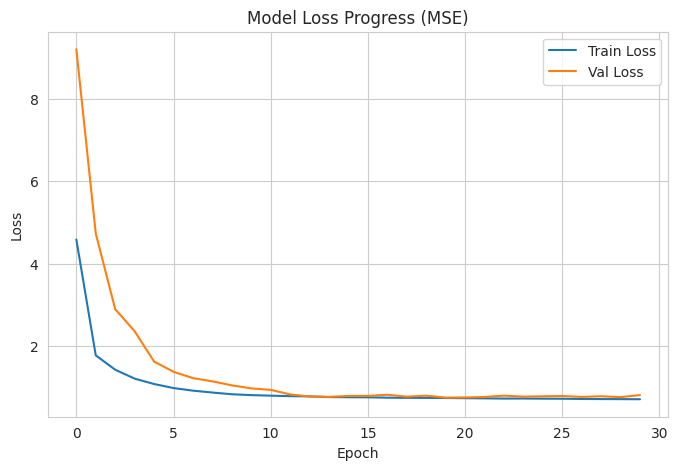

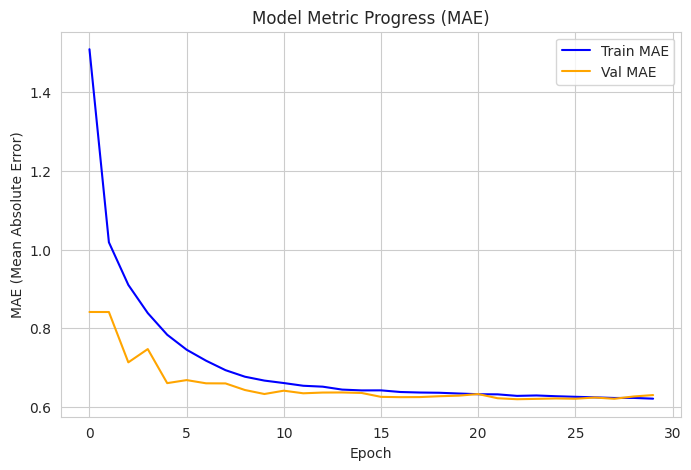

⬇️ Mengunduh dl_mae_history.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
#@title DL Training History & Summary
model_dl.summary()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Progress (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# --- Tambahan: Plot Training & Validation MAE per Epoch ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Train MAE', color='blue')
plt.plot(history.history['val_mae'], label='Val MAE', color='orange')
plt.title('Model Metric Progress (MAE)')
plt.ylabel('MAE (Mean Absolute Error)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.savefig('output_images/dl_mae_history.png') # Simpan gambar
plt.show()

print("⬇️ Mengunduh dl_mae_history.png...")
files.download('output_images/dl_mae_history.png')

In [38]:
#@title Evaluasi Deep Learning pada Test Set
y_pred_dl = model_dl.predict(X_test_scaled).flatten()

rmse_dl = np.sqrt(mean_squared_error(y_test, y_pred_dl))
mae_dl = mean_absolute_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)

print(f"Deep Learning Results:")
print(f"RMSE: {rmse_dl:.4f}")
print(f"MAE : {mae_dl:.4f}")
print(f"R2  : {r2_dl:.4f}")

248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
Deep Learning Results:
RMSE: 0.8554
MAE : 0.6282
R2  : 0.1465


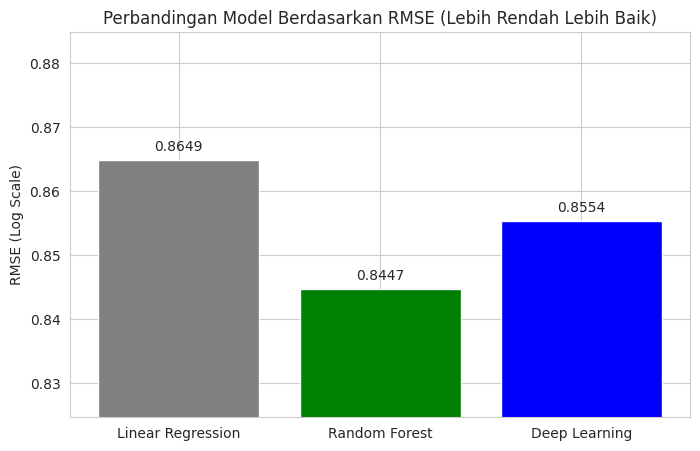

KESIMPULAN: Model terbaik adalah Random Forest dengan RMSE terendah.


In [39]:
#@title Perbandingan Akhir Ketiga Model
models_names = ['Linear Regression', 'Random Forest', 'Deep Learning']
rmses = [rmse_lr, rmse_rf, rmse_dl]

plt.figure(figsize=(8, 5))
bars = plt.bar(models_names, rmses, color=['gray', 'green', 'blue'])
plt.title('Perbandingan Model Berdasarkan RMSE (Lebih Rendah Lebih Baik)')
plt.ylabel('RMSE (Log Scale)')
plt.ylim(min(rmses)-0.02, max(rmses)+0.02)

# Label nilai
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

plt.show()

# Print Kesimpulan
best_idx = np.argmin(rmses)
print(f"KESIMPULAN: Model terbaik adalah {models_names[best_idx]} dengan RMSE terendah.")

In [40]:
!pip freeze > requirements.txt